In [1]:
# Import libraries
import numpy as np
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision import datasets
import matplotlib.pyplot as plt

import scipy.io
from sklearn.model_selection import train_test_split

## SECTION 1: Data loading and exploration

### Pre-processing the data

#### ToTensor():

- Conversion to PyTorch tensor: The transformation converts the input data from a PIL image or NumPy array format to a PyTorch tensor, which is the preferred format for working with deep learning models in PyTorch.

- Scaling pixel values: By default, pixel values in images are represented as integers in the range [0, 255]. transforms.ToTensor() automatically scales these values to a floating-point range of [0, 1] by dividing each pixel value by 255. This scaling process is beneficial because it ensures that the input values are within a consistent range, which generally improves the convergence and performance of neural networks during training.

- Channel order: When working with images, it's essential to have a consistent channel order across the dataset. In the case of PIL images and NumPy arrays, the channel order is typically in the format (height, width, channels) or (H, W, C). However, PyTorch models generally expect the input tensors to have a channel-first format, i.e., (channels, height, width) or (C, H, W). The transforms.ToTensor() function automatically reorders the channels to the expected format.

#### Normalization (mean 0.5, std 0.5):

Normalizing the data scales the input features to a common range, making it easier for the model to learn the relationships between the input and output. In the case of image data, normalization can also help mitigate the effects of different lighting conditions and contrast levels.

Since the MNIST images are grayscale, there is only one channel, and we use a single value for the mean and standard deviation.

The choice of 0.5 for both the mean and standard deviation is a simple and convenient way to normalize the pixel values. 


#### Result:

When you apply this transformation, the original pixel values (0 to 255) are first converted to a range of 0 to 1 (by the transforms.ToTensor() method) and then shifted and scaled by subtracting the mean and dividing by the standard deviation, obtaining values in a range [-1, 1]

In [2]:
# Establish our transform
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

In [3]:
# Custom MNIST dataset class
class CustomMNISTDataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.data[idx].reshape(28, 28)
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# Load the MNIST data
mat = scipy.io.loadmat('mnist-original.mat')
data = mat['data'].T
labels = mat['label'][0]


Images shape: torch.Size([64, 1, 28, 28])
Labels shape: torch.Size([64])


Let's split the data into train set, validation set and test set. Then let's create the custom datasets and dataloaders.

In [ ]:
# Split data into training and testing sets
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=1/7, random_state=42)
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size=0.1, random_state=42)

# Create custom datasets
train_dataset = CustomMNISTDataset(train_data, train_labels, transform=transform)
val_dataset = CustomMNISTDataset(val_data, val_labels, transform=transform)
test_dataset = CustomMNISTDataset(test_data, test_labels, transform=transform)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Check if the dataloaders are working
images, labels = next(iter(train_loader))
print(f'Images shape: {images.shape}')
print(f'Labels shape: {labels.shape}')

Let's explore the data. How many digits do we have in the training and test datasets?

In [4]:
print(f'Size of training dataset {len(train_loader.dataset)} handwritten digits')
print(f'Size of validation dataset {len(val_loader.dataset)} handwritten digits')
print(f'Size of test dataset {len(test_loader.dataset)} handwritten digits')

Size of training dataset 54000 handwritten digits
Size of validation dataset 6000 handwritten digits
Size of test dataset 10000 handwritten digits


How many batches do we have in our training and test dataloaders?

In [5]:
print(f'Number of batches in training loader: {len(train_loader)} batches')
print(f'Number of batches in validation loader: {len(val_loader)} batches')
print(f'Number of batches in test loader: {len(test_loader)} batches')

Number of batches in training loader: 844 batches
Number of batches in validation loader: 94 batches
Number of batches in test loader: 157 batches


Let's print one image from the training dataloader and its label:

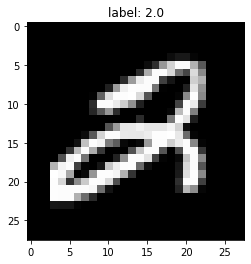

In [6]:
for i, data in enumerate(train_loader):
    if i==0:
        image, label = data
        image = image[0].squeeze()
        unnormalized_image = (image * 0.5) + 0.5

        plt.imshow(unnormalized_image, cmap='gray')
        plt.title(f'label: {label[0].item()}')
        plt.show()
    else:
        break

## SECTION 2: Model design and training

We will use PyTorch to build a neural network model for image classification, with the following constraints:
- At least 2 hidden layers
- Forward method that output a prediction probability for each one of the 10 classes using SOFTMAX

In [7]:
# Define the class for your neural network
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.activation = F.relu
        #self.output = F.softmax
        self.layer1 = nn.Linear(1*28*28,120) #120,84 Input size should be 1 (1 channel as it's grayscale) x 28 x 28 (28x28 pixels image size)
        self.layer2 = nn.Linear(120,84)
        self.layer3 = nn.Linear(84,10) # Output should be 10 as it's a 10 classes classification problem.

    def forward(self, x):
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.activation(self.layer1(x))
        x = self.activation(self.layer2(x))
        x = self.layer3(x)
        return x

# Instantiate the model
net = Net()

We define here the optimizer and the loss function of our network:

In [8]:
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.95)

criterion = nn.CrossEntropyLoss()

Let's define the function to train our neural network model.

2 extra features compare to the typical train loop:
- Validation dataset: The train dataset has been splitted into 2 set, one for pure training and another for validation. Then the loop provides the validation accuracy for each epoch.

- Visual representation of a wrong predicted digit for each epoch.

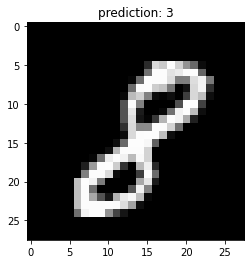

Epoch #1 Training accuracy: 77.76%, Training loss: 0.81
Epoch #1 Validation accuracy: 90.35%, Validation loss: 0.34


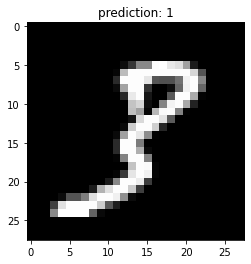

Epoch #2 Training accuracy: 90.37%, Training loss: 0.33
Epoch #2 Validation accuracy: 91.23%, Validation loss: 0.29


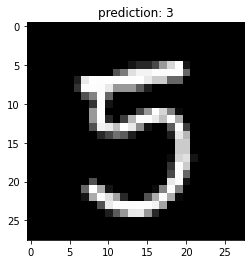

Epoch #3 Training accuracy: 91.89%, Training loss: 0.28
Epoch #3 Validation accuracy: 93.05%, Validation loss: 0.24


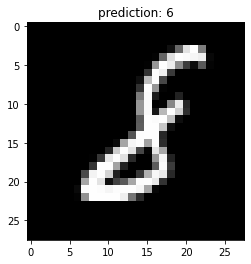

Epoch #4 Training accuracy: 93.07%, Training loss: 0.24
Epoch #4 Validation accuracy: 94.03%, Validation loss: 0.21


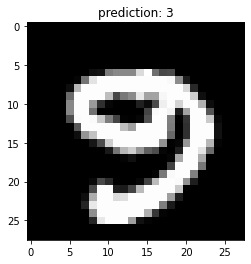

Epoch #5 Training accuracy: 94.04%, Training loss: 0.20
Epoch #5 Validation accuracy: 94.47%, Validation loss: 0.19


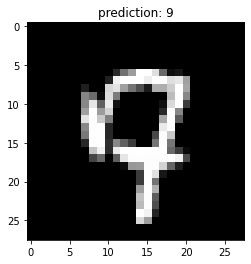

Epoch #6 Training accuracy: 94.59%, Training loss: 0.18
Epoch #6 Validation accuracy: 95.08%, Validation loss: 0.17


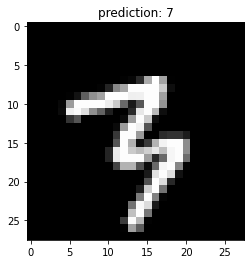

Epoch #7 Training accuracy: 95.38%, Training loss: 0.16
Epoch #7 Validation accuracy: 94.97%, Validation loss: 0.16


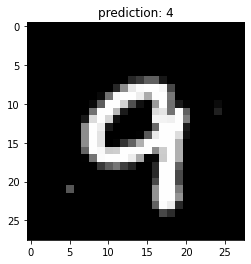

Epoch #8 Training accuracy: 95.81%, Training loss: 0.14
Epoch #8 Validation accuracy: 95.37%, Validation loss: 0.15


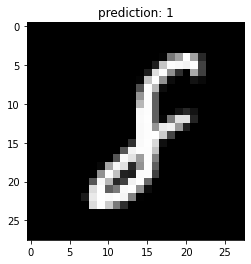

Epoch #9 Training accuracy: 96.26%, Training loss: 0.13
Epoch #9 Validation accuracy: 96.07%, Validation loss: 0.13


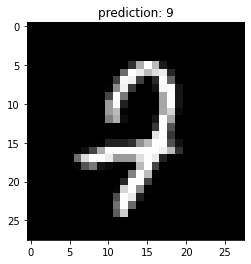

Epoch #10 Training accuracy: 96.58%, Training loss: 0.12
Epoch #10 Validation accuracy: 96.17%, Validation loss: 0.13


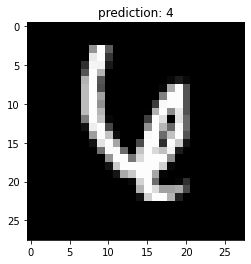

Epoch #11 Training accuracy: 96.83%, Training loss: 0.11
Epoch #11 Validation accuracy: 96.47%, Validation loss: 0.12


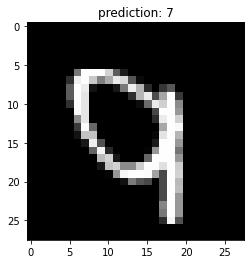

Epoch #12 Training accuracy: 97.02%, Training loss: 0.10
Epoch #12 Validation accuracy: 96.65%, Validation loss: 0.11


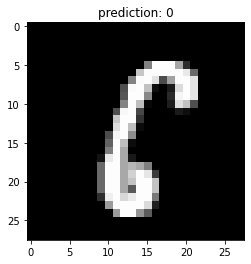

Epoch #13 Training accuracy: 97.27%, Training loss: 0.09
Epoch #13 Validation accuracy: 96.95%, Validation loss: 0.11


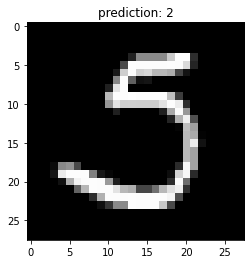

Epoch #14 Training accuracy: 97.36%, Training loss: 0.09
Epoch #14 Validation accuracy: 96.60%, Validation loss: 0.11


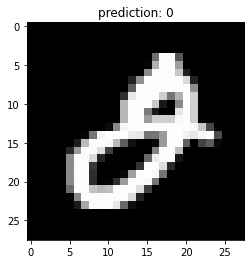

Epoch #15 Training accuracy: 97.64%, Training loss: 0.08
Epoch #15 Validation accuracy: 97.17%, Validation loss: 0.09


In [9]:
num_epochs = 15

# Establish a list of our history
train_loss_history = list()
test_loss_history = list()

for epoch in range(num_epochs):
    net.train()
    train_loss = 0.0
    train_correct = 0
    count = 0
    for i, data in enumerate(train_loader):
        inputs, labels = data
        
        # Ensure the input tensors have the correct data type (e.g., torch.float32 or torch.float64)
        inputs = inputs.to(torch.float32)
        labels = labels.long()
        
        if torch.cuda.is_available():
            inputs, labels = inputs.cuda(), labels.cuda()
        
        # Zero out the gradients of the optimizer
        optimizer.zero_grad()
        
        # Get the outputs of your model and compute your loss
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        
        # Compute the loss gradient using backward method and have the optimizer take a step
        loss.backward() 
        optimizer.step()
        
        # 
        _, preds = torch.max(outputs.data, 1) # preds = Tensor(64)
        train_correct += (preds == labels).sum().item()
        train_loss += loss.item()
        
        # Print an example of wrong prediction for each epoch
        
        no_correct_indexes = (preds != labels)
        for index in range(len(no_correct_indexes)):
            if no_correct_indexes[index] == 1 and count == 0:
                image = inputs[index].squeeze()
                unnormalized_image = (image * 0.5) + 0.5

                plt.imshow(unnormalized_image, cmap='gray')
                plt.title(f'prediction: {preds[index].item()}')
                plt.show()
                count = 1

    print(f'Epoch #{epoch+1} Training accuracy: {(100*train_correct/len(train_loader.dataset)):.2f}%, Training loss: {train_loss/len(train_loader):.2f}')
    train_loss_history.append(train_loss/len(train_loader))    
    
    val_loss = 0.0
    val_correct = 0
    net.eval()
    
    for i, data in enumerate(val_loader):
        inputs, labels = data
        inputs = inputs.to(torch.float32)
        labels = labels.long()
        
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        
        _, preds = torch.max(outputs.data, 1)
        val_correct += (preds == labels).sum().item()
        val_loss += loss.item()

    print(f'Epoch #{epoch+1} Validation accuracy: {(100*val_correct/len(val_loader.dataset)):.2f}%, Validation loss: {val_loss/len(val_loader):.2f}')
    test_loss_history.append(val_loss/(len(test_loader)))
        

Let's plot the training and validation loss history.

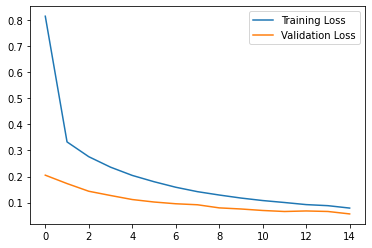

In [10]:
plt.plot(train_loss_history, label="Training Loss")
plt.plot(test_loss_history, label="Validation Loss")
plt.legend()
plt.show()

Validation loss curve don't stop decreasing or increases over the 15 epochs, which means that there is no overfitting.

## SECTION 3: Model testing and evaluation

Let's test our trained model with the testing dataset.

In [11]:
test_correct = 0
test_loss = 0.0

for i, data in enumerate(test_loader):
    inputs, labels = data
    
    inputs = inputs.to(torch.float32)
    labels = labels.long()
    
    outputs = net(inputs)
    loss = criterion(outputs, labels)
    _, preds = torch.max(outputs.data, 1)
    
    test_correct += (preds == labels).sum().item()
    test_loss += loss.item()
    
print(f'Testing accuracy: {100*test_correct/len(test_loader.dataset):.2f}%, Testing loss: {test_loss/len(test_loader):2f}')

Testing accuracy: 96.90%, Testing loss: 0.106906


#### The model obtain a testing accuracy of 96%, which is above the desired threshold (90%).

Let's save our model paramters.

In [12]:
torch.save(net.state_dict(), 'model_parameters.pt')